# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

from loguru import logger

In [2]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [3]:
fifa = pd.read_csv("fifa.csv")

In [4]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

## Inicia sua análise a partir daqui

In [5]:
# Sua análise começa aqui.
fifa.head(2)

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0


In [6]:
# Tamanho do df
fifa.shape

(18207, 37)

In [7]:
#Criando um dataframe auxliar para analisar a consistencia das variaveis
cons = pd.DataFrame({'colunas' : fifa.columns,
                    'tipo': fifa.dtypes,
                    'missing' : fifa.isna().sum(),
                    'size' : fifa.shape[0],
                    'unicos': fifa.nunique()})
cons['percentual'] = round(cons['missing'] / cons['size'],2)

In [8]:
cons

,colunas,tipo,missing,size,unicos,percentual
Age,Age,int64,0,18207,29,0.0
Overall,Overall,int64,0,18207,48,0.0
Potential,Potential,int64,0,18207,47,0.0
Crossing,Crossing,float64,48,18207,89,0.0
Finishing,Finishing,float64,48,18207,93,0.0
HeadingAccuracy,HeadingAccuracy,float64,48,18207,91,0.0
ShortPassing,ShortPassing,float64,48,18207,85,0.0
Volleys,Volleys,float64,48,18207,87,0.0
Dribbling,Dribbling,float64,48,18207,94,0.0
Curve,Curve,float64,48,18207,89,0.0


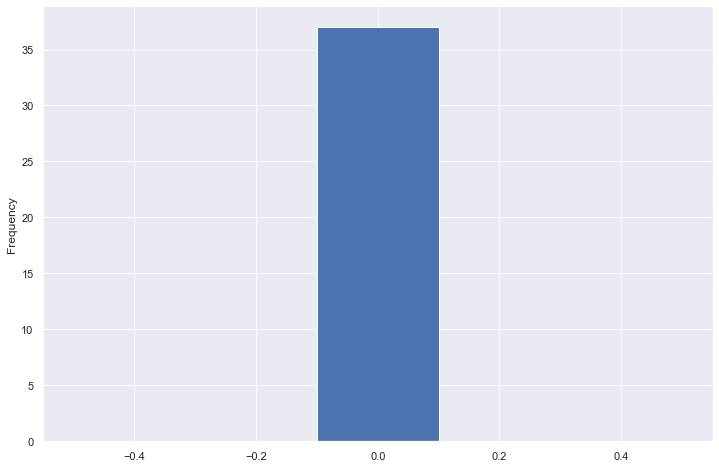

In [9]:
# Gráfico da consistencia das variaveis
cons.percentual.plot.hist( bins = 5)

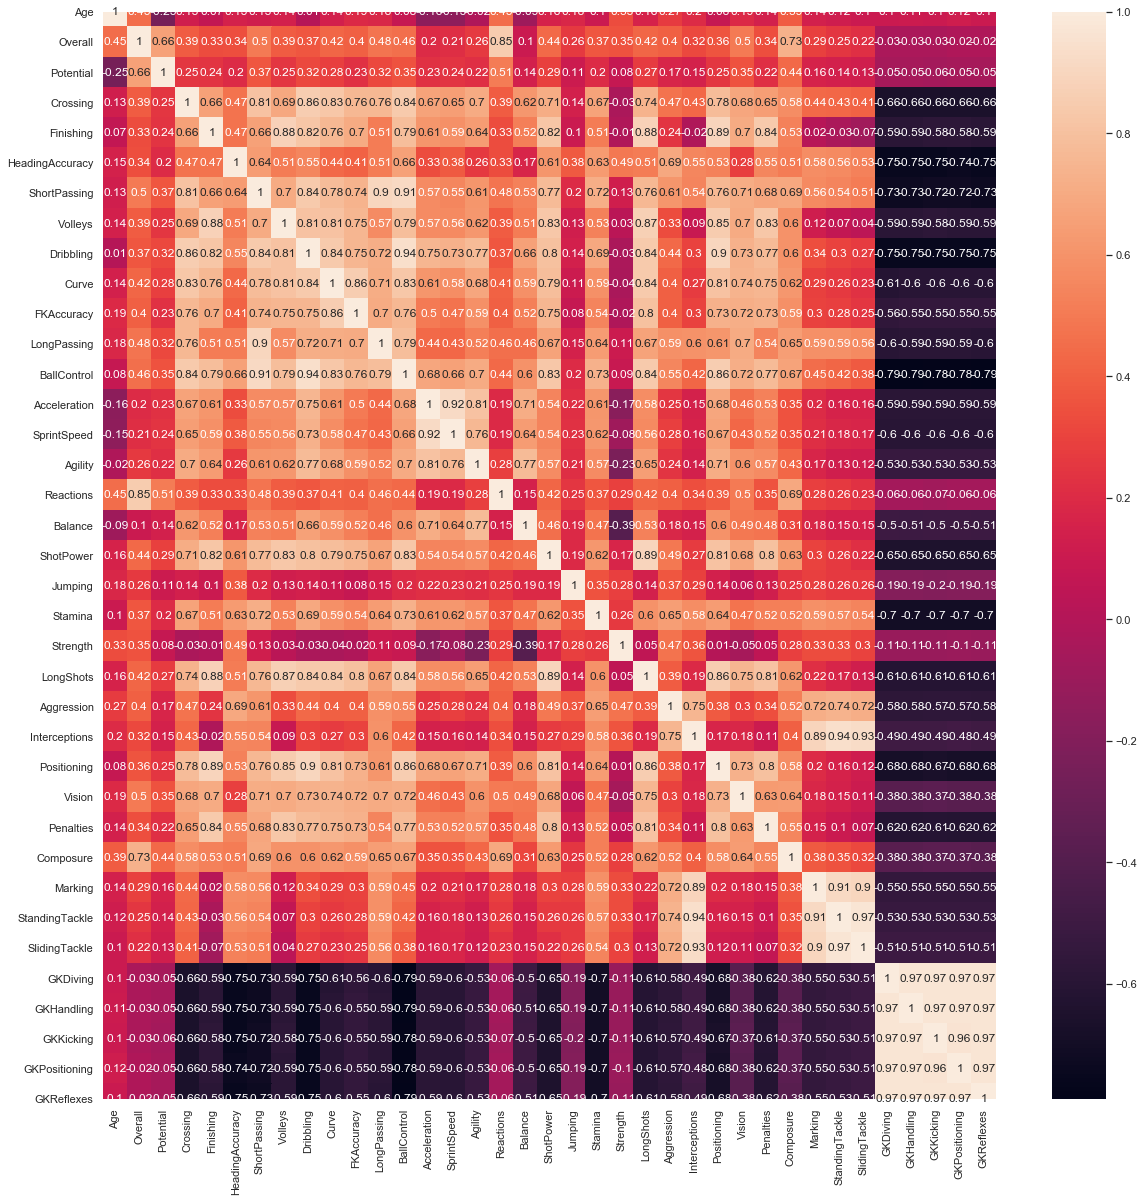

In [10]:
#Analisando a correlacao entre as variaveis númericas
plt.figure(figsize = (20,20))
sns.heatmap(fifa.corr().round(2), annot= True);

In [29]:
# Eliminando os nulos do df fifa
df = fifa.dropna()

In [30]:
# Redução da dimensionalidade utilizando PCA

pca = PCA(n_components=2)
projected = pca.fit_transform(df)
print(f"Original shape: {df.shape}, projected shape: {projected.shape}")

Original shape: (18159, 37), projected shape: (18159, 2)


In [31]:
# Variancia para a seleção de colunas do df

pca = PCA().fit(df)
evr = pca.explained_variance_ratio_
evr

array([5.65280555e-01, 1.81025219e-01, 5.95283391e-02, 4.34269284e-02,
       2.63532326e-02, 1.20707695e-02, 1.03550495e-02, 8.52951131e-03,
       7.87862979e-03, 7.20416677e-03, 7.18180297e-03, 6.32893542e-03,
       5.19242286e-03, 4.90798293e-03, 4.74209042e-03, 4.62772008e-03,
       4.25173246e-03, 3.86288432e-03, 3.76588448e-03, 3.75092615e-03,
       3.47815213e-03, 3.26730709e-03, 3.03137944e-03, 2.97415845e-03,
       2.56797543e-03, 2.30353342e-03, 2.14815132e-03, 1.56135904e-03,
       1.55351696e-03, 1.08664227e-03, 1.06824189e-03, 1.05891525e-03,
       9.58143746e-04, 8.89209394e-04, 8.59732430e-04, 7.34611045e-04,
       1.94187517e-04])

In [32]:
# Questão 1 - Variancia do primeiro componente principal do df
pca = PCA().fit(df)
evr = pca.explained_variance_ratio_
float(evr[0].round(3))

0.565

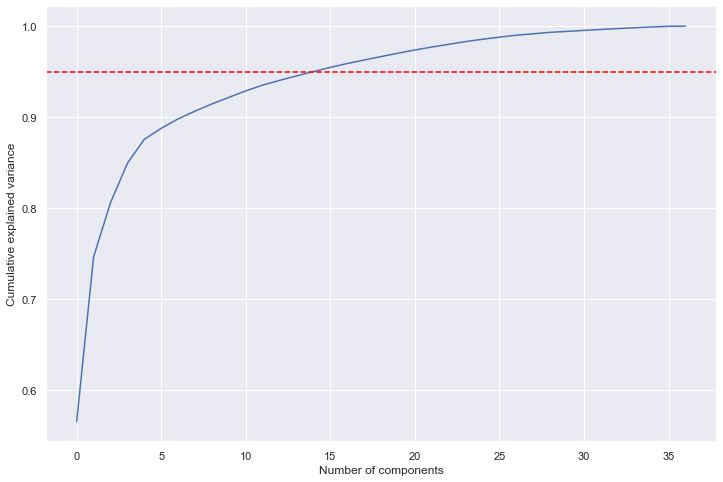

In [33]:
# Gráfico do numero de componentes para a variancia de 95% do total do df
g = sns.lineplot(np.arange(len(evr)), np.cumsum(evr))
g.axes.axhline(0.95, ls="--", color="red")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

In [34]:
# Soma da variacia acumulada
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
component_number = np.argmax(cumulative_variance_ratio >= 0.95) + 1 # Contagem começa em zero.

# Questão 2 - Qtd componentes principais para explicar 95% da variância total
int(component_number)

15

In [35]:
# Questão 2 - Qtd componentes principais para explicar 95% da variância total
# Desta vez pela própria função PCA

pca_095 = PCA(n_components=0.95)
features_reduced = pca_095.fit_transform(df)
features_reduced.shape[1] # Segundo elemento da tupla é o número de componentes encontrados.

15

In [36]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [37]:
# Questão 3 - Coordenadas (primeiro e segundo componentes principais) do ponto x 
# PCA pata os 2 primeiros componentes
pca = PCA(n_components=2).fit(df)
# Mutiplicação de matriz, os 2 componentes pela matriz x
pca.components_.dot(x).round(3)

array([186.556,  -6.592])

In [80]:
# Realizar regressão linear nos dados

X = df.drop('Overall', axis=1)
y = df.Overall

reg = LinearRegression().fit(X, y)

In [81]:
# Classificação de recursos com eliminação recursiva de recursos.

selecao = RFE(reg, 5)
selecao = selecao.fit(X, y)

In [82]:
# Retornar o index da classificação

index = selecao.get_support(True)

In [85]:
list(X.columns[index])

['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes']

In [84]:
selecao.support_

array([ True,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True])

In [63]:
selecao.ranking_

array([24, 14,  1,  1,  7,  2, 13, 27, 12,  5, 16, 11, 25,  9, 26, 23,  4,
       15, 20, 10, 18, 17, 21,  6, 22, 19,  3,  1,  8,  1,  1])

In [64]:
selecao.estimator_


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [74]:
# Questão 4 - RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma

X = df.drop('Overall', axis=1)
y = df.Overall
lista = []
contador = 0

# Para Eliminar uma a uma utilização do while para dropar a feture após sua seleção
# Dessa forma tanto a ordem quando a seleção de fearures é alterada
while contador < 5:
    reg = LinearRegression().fit(X, y)
    selecao = RFE(reg, 1)
    selecao = selecao.fit(X, y)
    index = selecao.get_support(True)
    feature = X.columns[index[0]]
    lista.append(feature)
    X = X.drop(feature, axis=1)
    contador = contador + 1
    
lista

['Age', 'Reactions', 'Potential', 'Composure', 'BallControl']

In [86]:
# Questão 4 - Selecionando as 5 variáveis de uma só vez, diferente do entendimento da questão

X = df.drop('Overall', axis=1)
y = df.Overall
reg = LinearRegression().fit(X, y)
selecao = RFE(reg, 5)
selecao = selecao.fit(X, y)
index = selecao.get_support(True)
list(X.columns[index])

['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes']

## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [6]:
def q1():
    pca = PCA().fit(df)
    evr = pca.explained_variance_ratio_
    return float(evr[0].round(3))

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

In [7]:
def q2():
    pca_095 = PCA(n_components=0.95)
    features_reduced = pca_095.fit_transform(df)
    return int(features_reduced.shape[1])

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [31]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [9]:
def q3():
    pca = PCA(n_components=2).fit(df)
    return tuple(pca.components_.dot(x).round(3))

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

In [10]:
def q4():
    X = df.drop('Overall', axis=1)
    y = df.Overall
    reg = LinearRegression().fit(X, y)
    selecao = RFE(reg, 5)
    selecao = selecao.fit(X, y)
    index = selecao.get_support(True)
    return list(X.columns[index])